### Analyzing counts

In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
import matplotlib.pyplot as plt

path_root = "/Users/atanaltay/Documents/Research/inwork/marketing_emotions/codes/data/all_marketing_data/"
#path_in = path_root+ "tr_emoanalysis.parquet"
path_in = path_root+ "tr_emoanalysis.parquet"


In [18]:
df = pd.read_parquet(path_in)


In [3]:
df.head()

,id,created_at,company,type,text,text_stemmed,short_name,industry,gender,text_demojized
__null_dask_index__,,,,,,,,,,
0,1208077577325305863,2019-12-20T17:31:54.000Z,cocacola,reply,@CocaCola_TR Ekonomik durum sıkıntılı bir güze...,ekonomik durum sıkıntı bir güzel yap artık bun...,cocacola,Food & Beverage,Uni,
1,1208075161360048128,2019-12-20T17:22:18.000Z,cocacola,reply,"@CocaCola_TR E 5,90 TL 'ymiş bu","e 5,90 tl i bu",cocacola,Food & Beverage,Uni,
2,1208072166463463424,2019-12-20T17:10:24.000Z,cocacola,reply,@CocaCola_TR Neden yapmam diye bir seçenek yok...,neden yap diye bir seçenek yok al lan kol bea...,cocacola,Food & Beverage,Uni,_beaming_face_with_smiling_eyes_
3,1208071864763011074,2019-12-20T17:09:12.000Z,cocacola,reply,@CocaCola_TR Oldu para vericem birde,ol par ver bird,cocacola,Food & Beverage,Uni,
4,1208071140863873025,2019-12-20T17:06:19.000Z,cocacola,reply,"@CocaCola_TR Krasnodar, kırım, Odessa, Kiev ha...",krasnodar kır odessa kiev markov kurban kursk ...,cocacola,Food & Beverage,Uni,


In [ ]:
counts = pd.DataFrame(np.hstack(df.text_demojized.str.split().to_list()))
#counts.drop()
counts = counts[counts[0].str.contains('[a-zA-Z]')==True]

dfToSave = pd.DataFrame(counts.value_counts(),columns=['cnt'])



dfToSave.to_csv(path_root + "tr_all_emoticon_counts.csv")

In [ ]:
dfcnt = pd.read_csv(path_root + "tr_all_emoticon_counts.csv")
#dfcnt= dfcnt[dfcnt.cnt>0]
dfcnt

,emoticon,cnt
0,_slightly_smiling_face_,17906
1,_blue_heart_,17477
2,_smiling_face_with_smiling_eyes_,12417
3,_red_heart_,12140
4,_face_with_tears_of_joy_,11006
...,...,...
1850,_trollface_,1
1851,_trolleybus_,1
1852,_person_cartwheeling_light_skin_tone_,1
1853,_person_dark_skin_tone_bald_,1


### Joining counts and emojis

In [55]:


#loading emoticons
all_emojis = pd.read_csv(path_root+'emoticon_analysis/emojis.csv')
# There are dublicate keys, so we remove them
all_emojis = all_emojis.drop_duplicates('name_demojized').set_index('name_demojized')

en_emos = pd.read_csv(path_root+"emoticon_analysis/tr_all_emoticon_counts.csv")
en_emos.index=en_emos.emoticon
en_emos.drop(columns='emoticon', inplace=True)
#en_emos = en_emos[en_emos.cnt>10]

df_joined = en_emos.join(all_emojis)
#clear non matching ones
df_joined = df_joined[pd.isnull(df_joined.emoji)==False]

# removing appearences less than 10
#df_joined_emojis = df_joined[df_joined.cnt>10]



In [59]:
df_joined.drop(columns=['codepoints','name_demojized.1']).to_csv(path_root+"emoticon_analysis/tr_emoticon_groups_and_counts.csv")

### Detailed Analysis

In [63]:

#we might get rid of this part (preparing vocabulary), as we have already demojized textx and count them
# yok vocabulary her türlü gerekioyr!!!!!! count vectorizer -'leri ayırarak saydı

#Prepare vocabulary

#loading seeds
#en_anger_seeds = pickle.load( open( path_root+"seeds/en/anger", "rb" ) )
#en_happy_seeds = pickle.load( open( path_root+"seeds/en/happy", "rb" ) )
#en_sad_seeds = pickle.load( open( path_root+"seeds/en/sad", "rb" ) )
#en_fear_seeds = pickle.load( open( path_root+"seeds/en/fear", "rb" ) )
#en_surprise_seeds = pickle.load( open( path_root+"seeds/en/surprise", "rb" ) )
#en_disgust_seeds = pickle.load( open( path_root+"seeds/en/disgust", "rb" ) )

#en_seeds_dict = {"anger":en_anger_seeds,"happy":en_happy_seeds,"sad":en_sad_seeds,"fear":en_fear_seeds,"surprise":en_surprise_seeds,"disgust":en_disgust_seeds}


#creating vocabulary dict
df_emo_data = pd.read_csv(path_root+"emoticon_analysis/tr_emoticon_groups_and_counts.csv")
vocab_list = df_emo_data.emoticon.to_list()

vocab_dict = dict()

for idx in range(len(vocab_list)):
    vocab_dict[vocab_list[idx]] = idx


df = pd.read_parquet(path_in,columns=['id','short_name','type','text_demojized','industry','gender'], engine='pyarrow')
df.index = df.id





In [67]:
vectorizer = CountVectorizer(vocabulary=vocab_dict,lowercase=False)
X = vectorizer.fit_transform(df.text_demojized)


In [81]:
type(X)

scipy.sparse.csr.csr_matrix

In [84]:
scipy.sparse.save_npz(path_root + "emoticon_analysis/count_matrices/tr/csr_count.npz",X)

In [91]:
X_col = X.tocsc()
scipy.sparse.save_npz(path_root + "emoticon_analysis/count_matrices/tr/csc_count.npz",X_col)

In [87]:
np.save(path_root + "emoticon_analysis/count_matrices/tr/feature_names.npy", vectorizer.get_feature_names_out())

In [88]:
#test

nums = scipy.sparse.load_npz(path_root + "emoticon_analysis/count_matrices/tr/csr_count.npz")

In [90]:
nums.sum()

219890

### Above basic conts are completed, we beging analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
import matplotlib.pyplot as plt

path_root = "/Users/atanaltay/Documents/Research/inwork/marketing_emotions/codes/data/all_marketing_data/"
cscPath = path_root + "emoticon_analysis/count_matrices/tr/csc_count.npz"
featuresPath = path_root + "emoticon_analysis/count_matrices/tr/feature_names.npy"
groupsAndCountsPath = path_root + "emoticon_analysis/tr_emoticon_groups_and_counts.csv"
emojisPath = path_root + "emoticon_analysis/emojis.csv"
path_in = path_root+ "tr_emoanalysis.parquet"

In [3]:

cscCountsMatrix = scipy.sparse.load_npz(cscPath)
featureNamesArray = np.load(featuresPath,allow_pickle=True)
groupsAndCountsDfTr = pd.read_csv(groupsAndCountsPath)
emojisdf = pd.read_csv(emojisPath)

In [16]:
groupsAndCountsDfEn = pd.read_csv(path_root + "emoticon_analysis/en_emoticon_groups_and_counts.csv")

In [24]:
groupsAndCountsDfTr.head()

,emoticon,cnt,emoji,name,group,sub_group
0,_slightly_smiling_face_,17906,🙂,slightly smiling face,Smileys & Emotion,face-smiling
1,_blue_heart_,17477,💙,blue heart,Smileys & Emotion,emotion
2,_smiling_face_with_smiling_eyes_,12417,😊,smiling face with smiling eyes,Smileys & Emotion,face-smiling
3,_red_heart_,12140,❤️,red heart,Smileys & Emotion,emotion
4,_face_with_tears_of_joy_,11006,😂,face with tears of joy,Smileys & Emotion,face-smiling


In [5]:
groups_tr = groupsAndCountsDfTr.groupby(["group","sub_group"])[['sub_group','cnt']].sum()


In [20]:
groups_tr.loc[('Smileys & Emotion')]

,cnt
sub_group,
cat-face,650
emotion,43591
face-affection,13057
face-concerned,12124
face-costume,460
face-glasses,3472
face-hand,6125
face-hat,1468
face-negative,6411


In [18]:
dfGroupTr = groupsAndCountsDfTr.groupby("group")[["group","cnt"]].sum()
dfGroupEn = groupsAndCountsDfEn.groupby("group")[["group","cnt"]].sum()

groupCounts = dfGroupTr.merge(dfGroupEn,left_index=True,right_index=True,suffixes=("Turkish","English"))

<AxesSubplot:title={'center':'Turkish Counts'}, xlabel='group'>

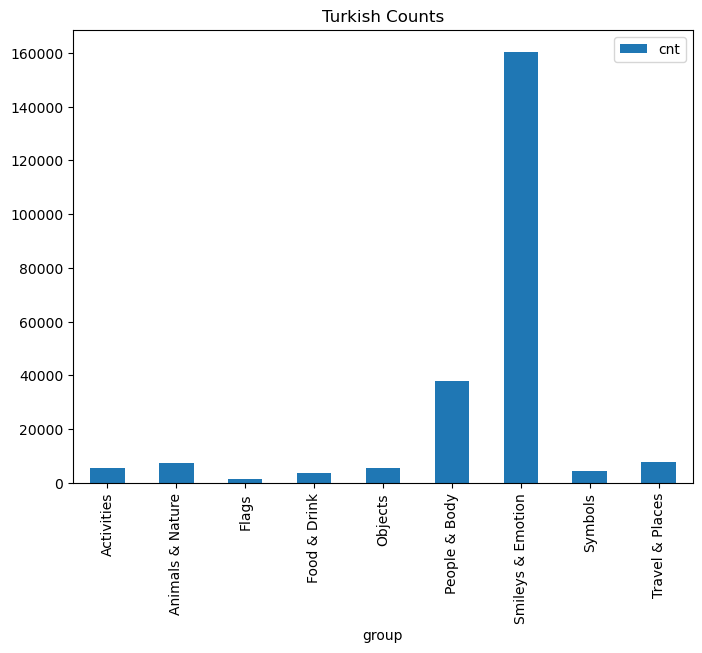

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
fig.set_dpi(100)
dfGroupTr.plot.bar(ax=ax,title="Turkish Counts")

<AxesSubplot:title={'center':'English Counts'}, xlabel='group'>

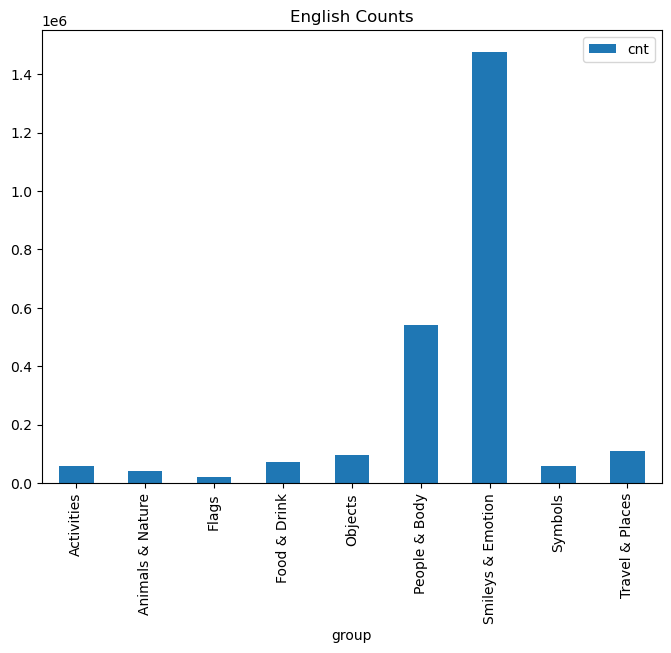

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig.set_dpi(100)
dfGroupEn.plot.bar(ax=ax,title="English Counts")

<AxesSubplot:title={'center':'Proportion of Emoji Types'}, xlabel='group'>

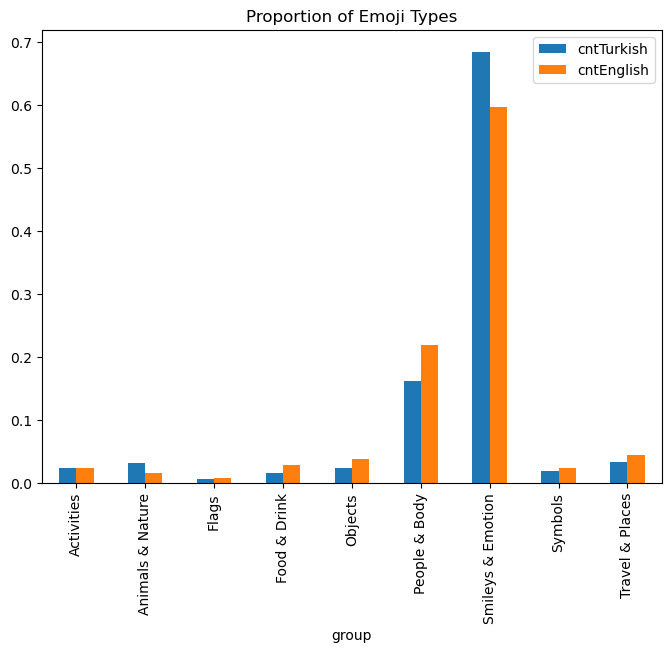

In [21]:

groupCounts = groupCounts/groupCounts.sum()
fig, ax = plt.subplots(figsize=(8,6))
fig.set_dpi(100)
groupCounts.plot.bar(ax=ax,title="Proportion of Emoji Types")


In [22]:

groupCounts = (groupCounts - groupCounts.mean())/groupCounts.std()

<AxesSubplot:xlabel='group'>

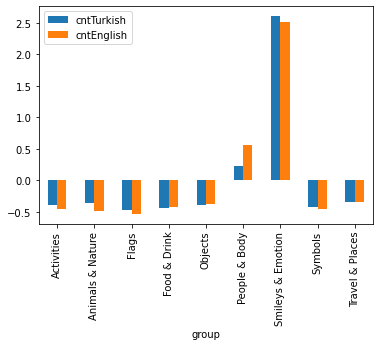

In [23]:
groupCounts.plot.bar()

grouping features: date groupings, type (reply/post), industry, gender

In [21]:
df = pd.read_parquet(path_in,columns=["id","created_at","company","type","industry","gender"])

In [23]:
df.head()

,id,created_at,company,type,industry,gender
__null_dask_index__,,,,,,
0,1208077577325305863,2019-12-20T17:31:54.000Z,cocacola,reply,Food & Beverage,Uni
1,1208075161360048128,2019-12-20T17:22:18.000Z,cocacola,reply,Food & Beverage,Uni
2,1208072166463463424,2019-12-20T17:10:24.000Z,cocacola,reply,Food & Beverage,Uni
3,1208071864763011074,2019-12-20T17:09:12.000Z,cocacola,reply,Food & Beverage,Uni
4,1208071140863873025,2019-12-20T17:06:19.000Z,cocacola,reply,Food & Beverage,Uni


In [48]:
#cscCountsMatrix
#featureNamesArray
#emojisdf


smileys = emojisdf[emojisdf.group=='Smileys & Emotion'].name_demojized.to_numpy()


In [2]:
#featureNamesArray


#The result is an array with indices for x array which corresponds to elements from y which were found in x.
indices = np.where(np.in1d(featureNamesArray, smileys))[0]

NameError: name 'np' is not defined

In [1]:
indices

NameError: name 'indices' is not defined

In [60]:
cscCountsMatrix.shape

(735459, 1840)

In [68]:
cscCountsMatrix[:,indices].sum(axis=1)

matrix([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]])